In [1]:
from torch import nn
import torch
import torchvision.transforms as T
from tqdm.notebook import tqdm
import os
import torch
from torch.utils.data import Dataset
from IPython.display import display

from unet import UNet
from torchvision.io import read_image

### Facades Dataset

In [67]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

--2023-07-13 15:51:27--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.1’

facades.tar.gz.1    100%[===================>]  28.77M  1.96MB/s    in 24s     

2023-07-13 15:51:51 (1.20 MB/s) - ‘facades.tar.gz.1’ saved [30168306/30168306]



In [ ]:
!ls ./facades/train

In [69]:
!tar -xf ./facades.tar.gz

In [ ]:
!mv  -v ./facades/val/* ./facades/train

In [2]:
class FacadesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = self._get_filenames(root_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # image_path = os.path.join(self.root_dir, self.image_filenames[idx])
        img_path = os.path.join(self.root_dir, self.image_filenames[idx])

        image = read_image(img_path).to(torch.float32)

        image1 = image[:, :256, :256]
        image2 = image[:, :256, 256:512]

        image1 = self.transform(image1)
        image2 = self.transform(image2)

        return image2, image1

    def _get_filenames(self, directory):
        filenames = sorted(os.listdir(directory))
        return filenames


### Load data, define parameters

0 in: 512 out: 512
1 in: 1024 out: 512
2 in: 1024 out: 512
3 in: 1024 out: 512
4 in: 1024 out: 256
5 in: 512 out: 128
6 in: 256 out: 64
7 in: 128 out: 3


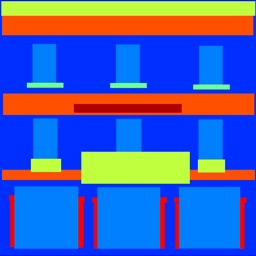

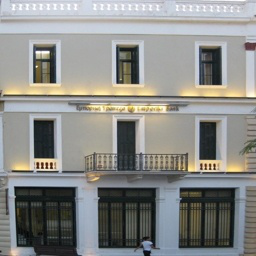

In [11]:
transform = T.Compose([
    T.Lambda(lambda x: x / 255),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    # T.RandomHorizontalFlip()
])

inverse_transform = T.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))

# =========================
# parameters
# =========================
device = "cuda:0" if torch.cuda.is_available() else "cpu"
EPOCHS = 20
batch_size = 32
model = UNet().to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


data_dir = '../data/facades/train/'
dataset = FacadesDataset(data_dir, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    # pin_memory_device=device,
    # pin_memory=True,
    drop_last=True
)


# Create a dataloader


batch = next(iter(dataloader))
X, y = batch
to_img = T.ToPILImage()

img1, img2 = X[0], y[0]
display(to_img(inverse_transform(img1)), to_img(inverse_transform(img2)));

### Train Unet with L1 loss

In [12]:
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = 0

    for X, y in tqdm(dataloader, leave=False, desc=f"Epoch {epoch}"):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)

        loss = criterion(pred, y)
        loss.backward()
        running_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()

    print(f"epoch {epoch}: loss={running_loss}")


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [160]:
test_data_dir = './facades/test/'
test_dataset = FacadesDataset(test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

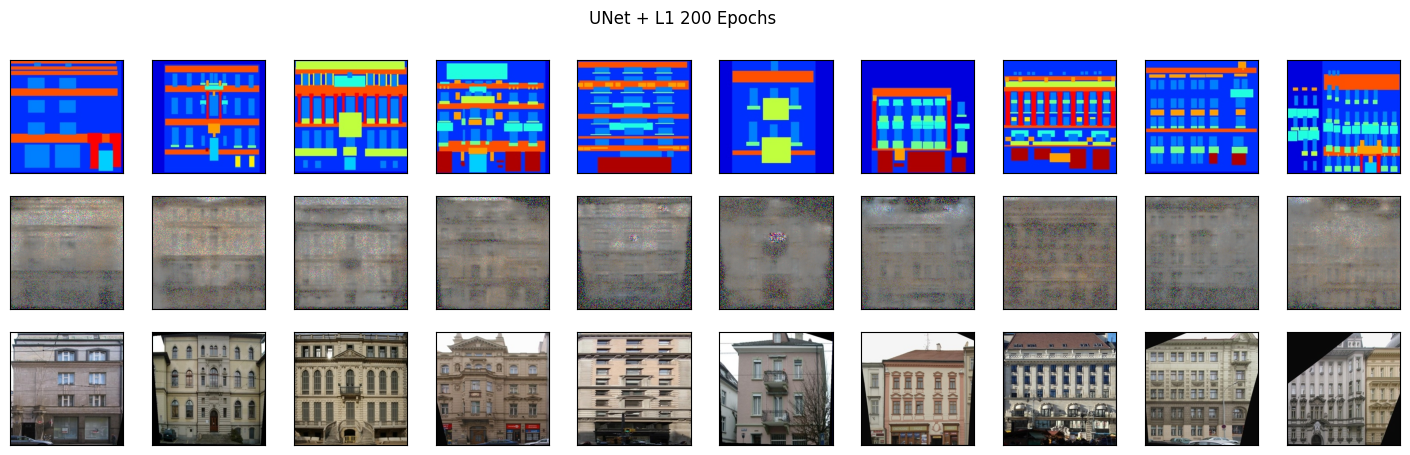

In [172]:
import matplotlib.pyplot as plt

def display_images(imgs):
    # imgs = list of three tensors
    # imgs = [X, pred, truth]
    num_imgs = len(imgs[0])
    fig, ax = plt.subplots(nrows=3, ncols=num_imgs, figsize=(18, 5))

    for i in range(3):
        for j in range(num_imgs):
            ax[i, j].imshow(imgs[i][j].numpy())
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.suptitle(f"UNet + L1 {EPOCHS} Epochs")


with torch.no_grad():
    batch = next(iter(testloader))

    X, y = batch
    # X = inverse_transform(X).permute(0, 2, 3, 1)
    # y = inverse_transform(y).permute(0, 2, 3, 1)

    pred = model(X.to(device)).cpu()

    pred_imgs = inverse_transform(pred).permute(0, 2, 3, 1)
    truth = inverse_transform(y).permute(0, 2, 3, 1)
    X = inverse_transform(X).permute(0, 2, 3, 1)

    # num_pictures = 10
    # display_images([X[:10], y[:10], y[:10]])

    display_images([X[:10], pred_imgs[:10], truth[:10]])
    plt.show()


In [162]:
torch.save(model.cpu(), "model.pt")
model = model.to(device)